# Regression
Practical of the course "Introduction to Machine Learning in Geophysics" held dy Dr. Francesco Grigoli within the MSc in Exploration and Applied Geophysics at the University of Pisa, Italy. This is a practical on the linear and polynomial regression.
Within this practical you will:
- Generate synthetic training and test datasets
- Apply different regression models to the data and evalute their performance
- Use the scikit-learn library for simple regression problems

## Loading required libraries
We will use numpy and matplotlib for data generation, manipulation and visualization.
Scikit-learn is the library we will use to solve our regression problem

In [1]:
import numpy as num
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Data Generation
We first define a set of utility functions that will help us in generating the data

In [2]:
def gen_data(x_min,x_max,n_points,noise_lev,ev_func):
    x=gen_input(x_min,x_max,n_points)
    y=gen_output(x,noise_lev,ev_func)
    return x,y

def gen_input(xmin,xmax,n_points):
    x_obs=xmin+num.random.rand(n_points)*(xmax-xmin)
    x_obs=num.sort(x_obs)
    return x_obs

def gen_output(x_obs,noise_lev,ev_func):
    y_obs=ev_func(x_obs)
    dy=gen_uncert(y_obs,noise_lev)
    return y_obs+dy

def gen_uncert(y_obs,noise_lev):
    dy=noise_lev*((2*num.random.rand(num.size(y_obs))-1)*num.mean(num.abs(y_obs)))
    return dy

def randindx(data_size,split_size):
    ind_x=num.array([])
    while num.size(ind_x)<split_size:
        jndx=num.random.randint(0,data_size,size=split_size-num.size(ind_x))
        ind_x=num.concatenate((ind_x,num.unique(jndx)))
    ind_x=ind_x.astype(int)
    return ind_x

def training_test_split(x_obs,y_obs,s_ratio=0.5):
    data_size=num.size(x_obs)
    split_size=int(data_size*s_ratio)
    ind_x=randindx(data_size,split_size)
    x_train,y_train=num.take(x_obs,ind_x),num.take(y_obs,ind_x)
    x_test,y_test=num.delete(x_obs,ind_x),num.delete(y_obs,ind_x)
    return x_train, y_train, x_test, y_test
    


We use the function **gen_data** to generate our synthetic dataset

In [3]:
x_min=0
x_max=20
n_points=500
noise_lev=0.1
ev_func=lambda x: x+2*num.cos(2*x)
x_obs,y_obs=gen_data(x_min,x_max,n_points,noise_lev,ev_func)

Let us split our data in *training* and *test* data and plot them

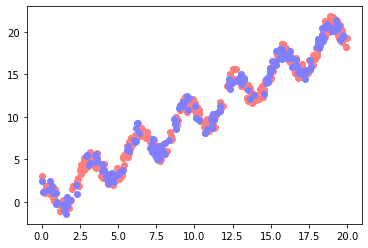

In [4]:
x_train, y_train, x_test, y_test=training_test_split(x_obs,y_obs,s_ratio=0.75)
plt.scatter(x_train, y_train, color='#FF7F7F', marker='o')
plt.scatter(x_test, y_test, color='#7F7FFF', marker='o')
plt.show()

## Regression
Here we define the functions needed for regression

In [5]:
def poly_regression(x_train,y_train,norder):
    G=genmat(x_train,norder)
    GG=num.dot(G.T,G)
    Ginv=num.linalg.inv(GG)
    m=num.dot((num.dot(Ginv,G.T)),y_train)
    return m

def genmat(x,norder):
    G=num.zeros([num.size(x),1+norder])
    for i in range(0,norder+1):
        G[:,i]= x**(i+1)
    G[:,-1]= 1
    return G

def regression_scikit(x_train,y_train,x_test,degree):
    X_train=x_train[:, num.newaxis]
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    X_test=x_test[:, num.newaxis]
    y_pred= model.predict(X_test)
    return y_pred, model

Solve the regression problem using the "home-made function" *poly_regression* and the scikit-learn library

In [6]:
norder=8
m_lsq=poly_regression(x_train,y_train,norder)
xmat=genmat(x_test,norder)
y_lsq=num.dot(m_lsq,xmat.T)
y_sci,model=regression_scikit(x_train,y_train,x_test,norder)

Plotting the results

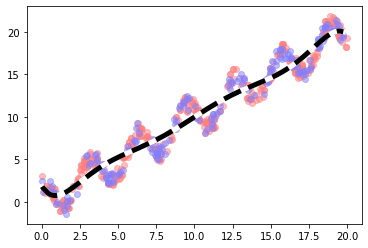

In [7]:
plt.scatter(x_train, y_train, color='#FF7F7F', marker='o',alpha=0.5)
plt.scatter(x_test, y_test, color='#7F7FFF', marker='o',alpha=0.5)
plt.plot(x_test,y_lsq, color='white',linewidth=5)
plt.plot(x_test,y_sci, color='black', linestyle='dashed', linewidth=5)

Calculate the Mean Squared Error (MSE)

In [8]:
mse_lsq=num.sqrt(num.sum((y_test-y_lsq)**2))/num.size(y_obs)
mse_sci=num.sqrt(num.sum((y_test-y_sci)**2))/num.size(y_obs)
print('least-squares mse: ', mse_lsq, 'scickit-learn mse: ', mse_sci)

least-squares mse:  0.04088703615840333 scickit-learn mse:  0.04088706141192233


Evaluate score for the training and test data
$$
R^{2}\left(\hat{y},y\right)=1-\frac{\sum_{i}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}}{\sum_{i}^{n}\left(y_{i}-<y>\right)^{2}}
$$
where
$$
<y>=\frac{1}{n}\sum_{i}^{n}y_{i}
$$

In [9]:
print('Score training {:.2f}'.format(model.score(x_train[:, num.newaxis],y_train)))
print('Score test     {:.2f}'.format(model.score(x_test[:, num.newaxis],y_test)))

Score training 0.94
Score test     0.94


Evaluate and plot the relative error

(-1.0, 1.0)

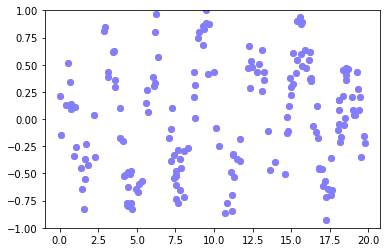

In [10]:
rel_err_sci=(y_test-y_sci)/num.max(num.abs(y_test-y_sci))
rel_err_lsq=(y_test-y_lsq)/num.max(num.abs(y_test-y_lsq))
plt.scatter(x_test, rel_err_lsq, color='#FF7F7F', marker='o')
plt.scatter(x_test, rel_err_sci, color='#7F7FFF', marker='o')
plt.ylim([-1,1])

In [11]:
def PCA(X,Y):
    XY=num.vstack((X,Y))
    M,N=num.shape(XY)
    XY_means = num.mean(XY,axis=1)[:,num.newaxis]
    XY_normalized = XY - XY_means
    Cov=(1/N)*num.dot(XY_normalized,XY_normalized.T)
    L,V=num.linalg.eigh(Cov)
    P = num.dot(V.T,XY)
    D = num.dot(V[:,1:].T,XY)
    W = num.dot(V[:,1:],D)
    return L,V,P,W

In [12]:
L,V,P,W=PCA(x_train,y_train)
c_train=(x_train+1j*y_train)*num.exp(1j*(45*num.pi/180))

(2, 375) (2, 375)


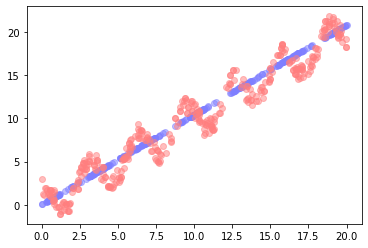

In [13]:
print(num.shape(P),num.shape(W))
plt.scatter(W[0,:],W[1,:],color='#7F7FFF', marker='o',alpha=0.5)
plt.scatter(x_train, y_train, color='#FF7F7F', marker='o',alpha=0.5)

(-10.0, 10.0)

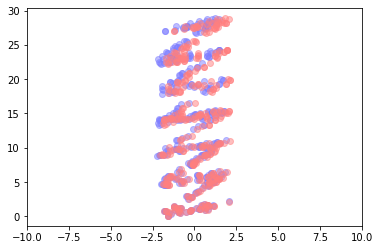

In [14]:
plt.scatter(P[0,:],P[1,:],color='#7F7FFF', marker='o',alpha=0.5)
plt.scatter(-c_train.real,c_train.imag,color='#FF7F7F', marker='o',alpha=0.5)
plt.xlim(-10,10)